# MNIST Prediction with Convolutional Neural Network

- MNIST dataset: is a dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images. More info can be found at the [MNIST homepage](http://yann.lecun.com/exdb/mnist/).
- Goal: build a simple artificial neural network to predict the digit in the images.
- Reference: [Oddly Satisfying Deep Learning](https://pythonandml.github.io/dlbook/content/convolutional_neural_networks/cnn_over_mlp.html)

#### Import libraries

In [1]:
# for linear algebra
import numpy as np

# for plotting data, loss, accuracy
import matplotlib.pyplot as plt

# loading mnist dataset from keras
from keras import datasets

# show progress bar
from tqdm import tqdm

# for type hinting
from typing import Optional, Union

#### 1. Utils Functions

1. **plot_data**: plot the random 8 images from the dataset.
2. **Base Layer**: Base class for all the layers.
3. **Activation Functions**: Linear, reLU, Sigmoid, Tanh, Softmax.
3. **Weight Initialization**: Zeros, Ones, Random, Random Uniform.
4. **Optimization Functions**: Gradient Descent, Stochastic Gradient Descent, RMSprop, Adam.

##### 1.1. Plotting Functions

In [2]:
def plot_data(
    X: np.ndarray, y: np.ndarray, y_proba: Optional[np.ndarray] = None
) -> None:
    nrows, ncols = 2, 4
    _, axes = plt.subplots(nrows, ncols, figsize=(8, 4))

    len_x = X.shape[0]
    for idx in range(nrows * ncols):
        ax = axes[idx // ncols, idx % ncols]

        img_idx = np.random.randint(0, len_x)

        ax.imshow(X[img_idx], cmap="gray")
        ax.set(xticks=[], yticks=[])

        true_label = f"True: {y[img_idx]}"
        color = "black"

        if y_proba is not None:
            pred_label = f"Pred: {y_proba[img_idx]}"
            color = "green" if y[img_idx] == y_proba[img_idx] else "red"

        img_title = true_label if y_proba is None else f"{true_label}\n{pred_label}"
        ax.set_xlabel(img_title, color=color)

    plt.tight_layout()
    plt.show()

##### 1.2. Activation Functions class

In [3]:
class Activation:

    def __init__(self, activation_type=None):
        """
        Parameters

        activation_type: type of activation
        available options are 'sigmoid', 'linear', 'tanh', 'softmax', 'prelu' and 'relu'
        """
        if activation_type is None:
            self.activation_type = "linear"
        else:
            self.activation_type = activation_type

    def linear(self, x):
        """
        Parameters

        x: input matrix of shape (m, d)
        where 'm' is the number of samples (in case of batch gradient descent of size m)
        and 'd' is the number of features
        """
        return x

    def d_linear(self, x):
        """
        Parameters

        x: input matrix of shape (m, d)
        where 'm' is the number of samples (in case of batch gradient descent of size m)
        and 'd' is the number of features
        """
        return np.ones(x.shape)

    def sigmoid(self, x):
        """
        Parameters

        x: input matrix of shape (m, d)
        where 'm' is the number of samples (in case of batch gradient descent of size m)
        and 'd' is the number of features
        """
        return 1 / (1 + np.exp(-x))

    def d_sigmoid(self, x):
        """
        Parameters

        x: input matrix of shape (m, d)
        where 'm' is the number of samples (in case of batch gradient descent of size m)
        and 'd' is the number of features
        """
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def tanh(self, x):
        """
        Parameters

        x: input matrix of shape (m, d)
        where 'm' is the number of samples (in case of batch gradient descent of size m)
        and 'd' is the number of features
        """
        return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

    def d_tanh(self, x):
        """
        Parameters

        x: input matrix of shape (m, d)
        where 'm' is the number of samples (in case of batch gradient descent of size m)
        and 'd' is the number of features
        """
        return 1 - (self.tanh(x)) ** 2

    def ReLU(self, x):
        """
        Parameters

        x: input matrix of shape (m, d)
        where 'm' is the number of samples (in case of batch gradient descent of size m)
        and 'd' is the number of features
        """
        return x * (x > 0)

    def d_ReLU(self, x):
        """
        Parameters

        x: input matrix of shape (m, d)
        where 'm' is the number of samples (in case of batch gradient descent of size m)
        and 'd' is the number of features
        """
        return (x > 0) * np.ones(x.shape)

    def PReLU(self, x, alpha=0.2):
        """
        Parameters
        alpha: slope parameter (𝛼)

        x: input matrix of shape (m, d)
        where 'm' is the number of samples (or rows)
        and 'd' is the number of features (or columns)
        """
        return np.where(x > 0, x, alpha * x)

    def d_PReLU(self, x, alpha=0.2):
        """
        Parameters
        alpha: slope parameter (𝛼)

        x: input matrix of shape (m, d)
        where 'm' is the number of samples (or rows)
        and 'd' is the number of features (or columns)
        """
        return np.where(x > 0, 1, alpha)

    def softmax(self, x):
        """
        Parameters

        x: input matrix of shape (m, d)
        where 'm' is the number of samples (in case of batch gradient descent of size m)
        and 'd' is the number of features
        """
        z = x - np.max(x, axis=-1, keepdims=True)
        numerator = np.exp(z)
        denominator = np.sum(numerator, axis=-1, keepdims=True)
        softmax = numerator / denominator
        return softmax

    def d_softmax(self, x):
        """
        Parameters

        x: input matrix of shape (m, d)
        where 'm' is the number of samples (in case of batch gradient descent of size m)
        and 'd' is the number of features
        """
        if len(x.shape) == 1:
            x = np.array(x).reshape(1, -1)
        else:
            x = np.array(x)
        m, d = x.shape
        a = self.softmax(x)
        tensor1 = np.einsum("ij,ik->ijk", a, a)
        tensor2 = np.einsum("ij,jk->ijk", a, np.eye(d, d))
        return tensor2 - tensor1

    def get_activation(self, x):
        """
        Parameters

        x: input matrix of shape (m, d)
        where 'm' is the number of samples (in case of batch gradient descent of size m)
        and 'd' is the number of features
        """
        if self.activation_type == "sigmoid":
            return self.sigmoid(x)
        elif self.activation_type == "tanh":
            return self.tanh(x)
        elif self.activation_type == "relu":
            return self.ReLU(x)
        elif self.activation_type == "linear":
            return self.linear(x)
        elif self.activation_type == "prelu":
            return self.PReLU(x)
        elif self.activation_type == "softmax":
            return self.softmax(x)
        else:
            raise ValueError(
                "Valid Activations are only 'sigmoid', 'linear', 'tanh' 'softmax', 'prelu' and 'relu'"
            )

    def get_d_activation(self, x):
        """
        Parameters

        x: input matrix of shape (m, d)
        where 'm' is the number of samples (in case of batch gradient descent of size m)
        and 'd' is the number of features
        """
        if self.activation_type == "sigmoid":
            return self.d_sigmoid(x)
        elif self.activation_type == "tanh":
            return self.d_tanh(x)
        elif self.activation_type == "relu":
            return self.d_ReLU(x)
        elif self.activation_type == "linear":
            return self.d_linear(x)
        elif self.activation_type == "prelu":
            return self.d_PReLU(x)
        elif self.activation_type == "softmax":
            return self.d_softmax(x)
        else:
            raise ValueError(
                "Valid Activations are only 'sigmoid', 'linear', 'tanh', 'softmax', 'prelu' and 'relu'"
            )

    def forward(self, X):
        self.X = X
        z = self.get_activation(X)
        return z

    def backpropagation(self, dz):
        f_prime = self.get_d_activation(self.X)
        if self.activation_type == "softmax":
            # because derivative of softmax is a tensor
            dx = np.einsum("ijk,ik->ij", f_prime, dz)
        else:
            dx = dz * f_prime
        return dx

##### 1.3. Weight Initialization class

- Zeros initialization: $w = np.zeros(shape)$
- Ones initialization: $w = np.ones(shape)$
- Random initialization: $w = np.random.randn(shape)$
- Random uniform initialization: $w = np.random.uniform(size=shape)$

In [4]:
class Weights_initializer:

    def __init__(self, shape, initializer_type=None, seed=None):
        """
        Parameters
        shape: Shape of the weight matrix

        initializer_type: type of weight initializer
        available options are 'zeros', 'ones', 'random_normal', 'random_uniform',
        'he_normal', 'xavier_normal' and 'glorot_normal'
        """
        self.shape = shape
        if initializer_type is None:
            self.initializer_type = "he_normal"
        else:
            self.initializer_type = initializer_type
        self.seed = seed

    def zeros_initializer(self):
        if self.seed is not None:
            np.random.seed(self.seed)
        return np.zeros(self.shape)

    def ones_initializer(self):
        if self.seed is not None:
            np.random.seed(self.seed)
        return np.ones(self.shape)

    def random_normal_initializer(self):
        if self.seed is not None:
            np.random.seed(self.seed)
        return np.random.normal(size=self.shape)

    def random_uniform_initializer(self):
        if self.seed is not None:
            np.random.seed(self.seed)
        return np.random.uniform(size=self.shape)

    def he_initializer(self):
        if self.seed is not None:
            np.random.seed(self.seed)
        try:
            F, Kc, Kh, Kw = self.shape
        except:
            Kh, Kw = self.shape
        return np.random.randn(*self.shape) * np.sqrt(2 / Kh)

    def xavier_initializer(self):
        """
        shape: Shape of the Kernel matrix.
        """
        if self.seed is not None:
            np.random.seed(self.seed)
        try:
            F, Kc, Kh, Kw = self.shape
        except:
            Kh, Kw = self.shape
        return np.random.randn(*self.shape) * np.sqrt(1 / Kh)

    def glorot_initializer(self):
        """
        shape: Shape of the weight matrix.
        """
        if self.seed is not None:
            np.random.seed(self.seed)
        try:
            F, Kc, Kh, Kw = self.shape
        except:
            Kh, Kw = self.shape
        return np.random.randn(*self.shape) * np.sqrt(2 / (Kh + Kw))

    def get_initializer(self):
        if self.initializer_type == "zeros":
            return self.zeros_initializer()
        elif self.initializer_type == "ones":
            return self.ones_initializer()
        elif self.initializer_type == "random_normal":
            return self.random_normal_initializer()
        elif self.initializer_type == "random_uniform":
            return self.random_uniform_initializer()
        elif self.initializer_type == "he_normal":
            return self.he_initializer()
        elif self.initializer_type == "xavier_normal":
            return self.xavier_initializer()
        elif self.initializer_type == "glorot_normal":
            return self.glorot_initializer()
        else:
            raise ValueError(
                "Valid initializer options are 'zeros', 'ones', 'random_normal', 'random_uniform', 'he_normal', 'xavier_normal', and 'glorot_normal'"
            )

##### 1.4.  Optimizers class

- Gradient Descent Optimizer: $w = w - \alpha \nabla_w L(w)$
- Stochastic Gradient Descent Optimizer: $w = w - \alpha \nabla_w L(w)$
- RMSprop Optimizer: $v = \beta v + (1 - \beta) \nabla_w L(w) \odot \nabla_w L(w)$ and $w = w - \alpha \frac{\nabla_w L(w)}{\sqrt{v + \epsilon}}$
- Adam Optimizer: $m = \beta_1 m + (1 - \beta_1) \nabla_w L(w)$, $v = \beta_2 v + (1 - \beta_2) \nabla_w L(w) \odot \nabla_w L(w)$, $m_{\text{corrected}} = \frac{m}{1 - \beta_1^t}$, $v_{\text{corrected}} = \frac{v}{1 - \beta_2^t}$, and $w = w - \alpha \frac{m_{\text{corrected}}}{\sqrt{v_{\text{corrected}} + \epsilon}}$

> Note: Actually, i only use the Gradient Descent Optimizer in this notebook.

In [5]:
class Optimizer:

    def __init__(
        self,
        optimizer_type=None,
        shape_W=None,
        shape_b=None,
        momentum1=0.9,
        momentum2=0.999,
        epsilon=1e-8,
    ):
        """
        Parameters

        momentum1: float hyperparameter >= 0 that accelerates gradient descent in the relevant
                   direction and dampens oscillations. Defaults to 0, i.e., vanilla gradient descent.
                   Also used in RMSProp
        momentum2: used in Adam only
        optimizer_type: type of optimizer
                        available options are 'gd', 'sgd' (This also includes momentum), 'adam', and 'rmsprop'
        shape_W: Shape of the weight matrix W/ Kernel K
        shape_b: Shape of the bias matrix b
        epsilon: parameter used in RMSProp and Adam to avoid division by zero error
        """

        if optimizer_type is None:
            self.optimizer_type = "adam"
        else:
            self.optimizer_type = optimizer_type

        self.momentum1 = momentum1
        self.momentum2 = momentum2
        self.epsilon = epsilon

        self.vdW = np.zeros(shape_W)
        self.vdb = np.zeros(shape_b)

        self.SdW = np.zeros(shape_W)
        self.Sdb = np.zeros(shape_b)

    def GD(self, dW, db, k):
        """
        dW: gradient of Weight W for iteration k
        db: gradient of bias b for iteration k
        k: iteration number
        """
        return dW, db

    def SGD(self, dW, db, k):
        """
        dW: gradient of Weight W for iteration k
        db: gradient of bias b for iteration k
        k: iteration number
        """
        self.vdW = self.momentum1 * self.vdW + (1 - self.momentum1) * dW
        self.vdb = self.momentum1 * self.vdb + (1 - self.momentum1) * db

        return self.vdW, self.vdb

    def RMSProp(self, dW, db, k):
        """
        dW: gradient of Weight W for iteration k
        db: gradient of bias b for iteration k
        k: iteration number
        """
        self.SdW = self.momentum2 * self.SdW + (1 - self.momentum2) * (dW**2)
        self.Sdb = self.momentum2 * self.Sdb + (1 - self.momentum2) * (db**2)

        den_W = np.sqrt(self.SdW) + self.epsilon
        den_b = np.sqrt(self.Sdb) + self.epsilon

        return dW / den_W, db / den_b

    def Adam(self, dW, db, k):
        """
        dW: gradient of Weight W for iteration k
        db: gradient of bias b for iteration k
        k: iteration number
        """
        # momentum
        self.vdW = self.momentum1 * self.vdW + (1 - self.momentum1) * dW
        self.vdb = self.momentum1 * self.vdb + (1 - self.momentum1) * db

        # rmsprop
        self.SdW = self.momentum2 * self.SdW + (1 - self.momentum2) * (dW**2)
        self.Sdb = self.momentum2 * self.Sdb + (1 - self.momentum2) * (db**2)

        # correction
        if k > 1:
            vdW_h = self.vdW / (1 - (self.momentum1**k))
            vdb_h = self.vdb / (1 - (self.momentum1**k))
            SdW_h = self.SdW / (1 - (self.momentum2**k))
            Sdb_h = self.Sdb / (1 - (self.momentum2**k))
        else:
            vdW_h = self.vdW
            vdb_h = self.vdb
            SdW_h = self.SdW
            Sdb_h = self.Sdb

        den_W = np.sqrt(SdW_h) + self.epsilon
        den_b = np.sqrt(Sdb_h) + self.epsilon

        return vdW_h / den_W, vdb_h / den_b

    def get_optimization(self, dW, db, k):
        if self.optimizer_type == "gd":
            return self.GD(dW, db, k)
        if self.optimizer_type == "sgd":
            return self.SGD(dW, db, k)
        if self.optimizer_type == "rmsprop":
            return self.RMSProp(dW, db, k)
        if self.optimizer_type == "adam":
            return self.Adam(dW, db, k)
        else:
            raise ValueError(
                "Valid optimizer options are only 'gd', 'sgd', 'rmsprop', and 'adam'."
            )

##### 1.5. Cost Functions class

- Mean Squared Error Loss: $L(y, \hat{y}) = \frac{1}{2} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$
- Derivative of Mean Squared Error Loss: $\frac{\partial L(y, \hat{y})}{\partial \hat{y}} = \hat{y} - y$
- Binary Cross Entropy Loss: $L(y, \hat{y}) = - \sum_{i=1}^{n} y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)$
- Derivative of Binary Cross Entropy Loss: $\frac{\partial L(y, \hat{y})}{\partial \hat{y}} = - \frac{y}{\hat{y}} + \frac{1 - y}{1 - \hat{y}$

In [6]:
class Cost:

    def __init__(self, cost_type="mse"):
        """
        Parameters

        cost_type: type of cost function
        available options are 'mse', and 'cross-entropy'
        """
        self.cost_type = cost_type

    def mse(self, a, y):
        """
        Parameters

        a: Predicted output array of shape (m, d)
        y: Actual output array of shape (m, d)
        """
        return (1 / 2) * np.sum((np.linalg.norm(a - y, axis=1)) ** 2)

    def d_mse(self, a, y):
        """
        represents dJ/da

        Parameters

        a: Predicted output array of shape (m, d)
        y: Actual output array of shape (m, d)
        """
        return a - y

    def cross_entropy(self, a, y, epsilon=1e-12):
        """
        Parameters

        a: Predicted output array of shape (m, d)
        y: Actual output array of shape (m, d)
        """
        a = np.clip(a, epsilon, 1.0 - epsilon)
        return -np.sum(y * np.log(a))

    def d_cross_entropy(self, a, y, epsilon=1e-12):
        """
        represents dJ/da

        Parameters

        a: Predicted output array of shape (m, d)
        y: Actual output array of shape (m, d)
        """
        a = np.clip(a, epsilon, 1.0 - epsilon)
        return -y / a

    def get_cost(self, a, y):
        """
        Parameters

        a: Predicted output array of shape (m, d)
        y: Actual output array of shape (m, d)
        """
        if self.cost_type == "mse":
            return self.mse(a, y)
        elif self.cost_type == "cross-entropy":
            return self.cross_entropy(a, y)
        else:
            raise ValueError("Valid cost functions are only 'mse', and 'cross-entropy'")

    def get_d_cost(self, a, y):
        """
        Parameters

        a: Predicted output array of shape (m, d)
        y: Actual output array of shape (m, d)
        """
        if self.cost_type == "mse":
            return self.d_mse(a, y)
        elif self.cost_type == "cross-entropy":
            return self.d_cross_entropy(a, y)
        else:
            raise ValueError("Valid cost functions are only 'mse', and 'cross-entropy'")

##### 1.6. Batch Normalization Layer

In [7]:
class BatchNormalization:

    def __init__(self, momentum=0.9, epsilon=1e-6):
        """
        Parameters

        momentum: Momentum for the moving average
        epsilon: 𝜖, Small float added to variance to avoid dividing by zero
        """
        self.epsilon = epsilon
        self.momentum = momentum

    def initialize_parameters(self, d):
        """
        d: Shape of input to BN layer
        """
        self.gamma = np.ones((d))
        self.beta = np.zeros((d))
        self.running_mean = np.zeros((d))
        self.running_var = np.zeros((d))

    def forward(self, z, mode="train"):
        """
        z: Input to BN layer
        mode: forward pass used for train or test
        """
        if mode == "train":
            self.m, self.d = z.shape
            self.mu = np.mean(z, axis=0)  # 𝜇
            self.var = np.var(z, axis=0)  # 𝜎^2
            self.zmu = z - self.mu  # z - 𝜇
            self.ivar = 1 / np.sqrt(self.var + self.epsilon)  # 𝜎𝑖𝑛𝑣
            self.zhat = self.zmu * self.ivar
            q = self.gamma * self.zhat + self.beta  # ql
            self.running_mean = (
                self.momentum * self.running_mean + (1 - self.momentum) * self.mu
            )
            self.running_var = (
                self.momentum * self.running_var + (1 - self.momentum) * self.var
            )
        elif mode == "test":
            q = (z - self.running_mean) / np.sqrt(self.running_var + self.epsilon)
            q = self.gamma * q + self.beta
        else:
            raise ValueError('Invalid forward batchnorm mode "%s"' % mode)
        return q

    def backpropagation(self, dq):
        self.dgamma = np.sum(dq * self.zhat, axis=0)
        self.dbeta = np.sum(dq, axis=0)
        dzhat = dq * self.gamma
        dvar = np.sum(dzhat * self.zmu * (-0.5) * (self.ivar**3), axis=0)
        dmu = np.sum(dzhat * (-self.ivar), axis=0)
        dz = dzhat * self.ivar + dvar * (2 / self.m) * self.zmu + (1 / self.m) * dmu
        return dz

    def update(self, lr, m, k):
        """
        Parameters:

        lr: learning rate
        m: batch_size (sumber of samples in batch)
        k: iteration_number
        """
        self.gamma -= self.dgamma * (lr / m)
        self.beta -= self.dbeta * (lr / m)

##### 1.7. Learning Rate Decay class

In [8]:
class LearningRateDecay:

    def __init__(self):
        pass

    def constant(self, t, lr_0):
        """
        t: iteration
        lr_0: initial learning rate
        """
        return lr_0

    def time_decay(self, t, lr_0, k):
        """
        lr_0: initial learning rate
        k: Decay rate
        t: iteration number
        """
        lr = lr_0 / (1 + (k * t))
        return lr

    def step_decay(self, t, lr_0, F, D):
        """
        lr_0: initial learning rate
        F: factor value controlling the rate in which the learning date drops
        D: “Drop every” iteration
        t: current iteration
        """
        mult = F ** np.floor((1 + t) / D)
        lr = lr_0 * mult
        return lr

    def exponential_decay(self, t, lr_0, k):
        """
        lr_0: initial learning rate
        k: Exponential Decay rate
        t: iteration number
        """
        lr = lr_0 * np.exp(-k * t)
        return lr

##### 1.8. Library class

In [9]:
class Utility:

    def __init__(self):
        pass

    def label_encoding(self, Y):
        """
        Parameters:
        Y: (m,d) shape matrix with categorical data
        Return
        result: label encoded data of 𝑌
        idx_list: list of the dictionaries containing the unique values
                  of the columns and their mapping to the integer.
        """
        idx_list = []
        result = []
        for col in range(Y.shape[1]):
            indexes = {val: idx for idx, val in enumerate(np.unique(Y[:, col]))}
            result.append([indexes[s] for s in Y[:, col]])
            idx_list.append(indexes)
        return np.array(result).T, idx_list

    def onehot(self, X):
        """
        Parameters:
        X: 1D array of labels of length "m"
        Return
        X_onehot: (m,d) one hot encoded matrix (one-hot of X)
                  (where d is the number of unique values in X)
        indexes: dictionary containing the unique values of X and their mapping to the integer column
        """
        indexes = {val: idx for idx, val in enumerate(np.unique(X))}
        y = np.array([indexes[s] for s in X])
        X_onehot = np.zeros((y.size, len(indexes)))
        X_onehot[np.arange(y.size), y] = 1
        return X_onehot, indexes

    def minmax(self, X, min_X=None, max_X=None):
        if min_X is None:
            min_X = np.min(X, axis=0)
        if max_X is None:
            max_X = np.max(X, axis=0)
        Z = (X - min_X) / (max_X - min_X)
        return Z, min_X, max_X

    def standardize(self, X, mu=None, std=None):
        if mu is None:
            mu = np.mean(X, axis=0)
        if std is None:
            std = np.std(X, axis=0)
        Z = (X - mu) / std
        return Z, mu, std

    def inv_standardize(self, Z, mu, std):
        X = Z * std + mu
        return X

    def train_test_split(self, X, y, test_ratio=0.2, seed=None):
        if seed is not None:
            np.random.seed(seed)
        train_ratio = 1 - test_ratio
        indices = np.random.permutation(X.shape[0])
        train_idx, test_idx = (
            indices[: int(train_ratio * len(X))],
            indices[int(train_ratio * len(X)) :],
        )
        X_train, X_test = X[train_idx, :], X[test_idx, :]
        y_train, y_test = y[train_idx], y[test_idx]
        return X_train, X_test, y_train, y_test

#### 2. Convolutional Neural Network

##### 2.1. Convolutional Layer

In [10]:
class Padding2D:

    def __init__(self, p="valid"):
        """
        Parameters:

        p: padding type
        Allowed types are only 'same', 'valid', an integer or a tuple of length 2.
        """
        self.p = p

    def get_dimensions(self, input_shape, kernel_size, s=(1, 1)):
        """
        Utility function to help get the dimension of the output after padding
        """
        if len(input_shape) == 4:
            m, Nc, Nh, Nw = input_shape
        elif len(input_shape) == 3:
            Nc, Nh, Nw = input_shape

        Kh, Kw = kernel_size
        sh, sw = s
        p = self.p

        if type(p) == int:
            pt, pb = p, p
            pl, pr = p, p

        if type(p) == tuple:
            ph, pw = p
            pt, pb = ph // 2, (ph + 1) // 2
            pl, pr = pw // 2, (pw + 1) // 2

        elif p == "valid":
            pt, pb = 0, 0
            pl, pr = 0, 0

        elif p == "same":
            # calculating how much padding is required in all 4 directions
            # (top, bottom, left and right)
            ph = (sh - 1) * Nh + Kh - sh
            pw = (sw - 1) * Nw + Kw - sw

            pt, pb = ph // 2, (ph + 1) // 2
            pl, pr = pw // 2, (pw + 1) // 2

        else:
            raise ValueError(
                "Incorrect padding type. Allowed types are only 'same', 'valid', an integer or a tuple of length 2."
            )

        if len(input_shape) == 4:
            output_shape = (m, Nc, Nh + pt + pb, Nw + pl + pr)
        elif len(input_shape) == 3:
            output_shape = (Nc, Nh + pt + pb, Nw + pl + pr)

        return output_shape, (pt, pb, pl, pr)

    def forward(self, X, kernel_size, s=(1, 1)):
        """
        Parameters:

        X: input of shape (m, Nc, Nh, Nw)

        s: strides along height and width (sh, sw)

        kernel_size: kernel size as specified in Conv2D layer

        Returns:

        Xp: padded X
        """
        self.input_shape = X.shape
        m, Nc, Nh, Nw = self.input_shape

        self.output_shape, (self.pt, self.pb, self.pl, self.pr) = self.get_dimensions(
            self.input_shape, kernel_size, s=s
        )

        zeros_r = np.zeros((m, Nc, Nh, self.pr))
        zeros_l = np.zeros((m, Nc, Nh, self.pl))
        zeros_t = np.zeros((m, Nc, self.pt, Nw + self.pl + self.pr))
        zeros_b = np.zeros((m, Nc, self.pb, Nw + self.pl + self.pr))

        Xp = np.concatenate((X, zeros_r), axis=3)
        Xp = np.concatenate((zeros_l, Xp), axis=3)
        Xp = np.concatenate((zeros_t, Xp), axis=2)
        Xp = np.concatenate((Xp, zeros_b), axis=2)

        return Xp

    def backpropagation(self, dXp):
        """
        Parameters:

        dXp: Backprop Error of padded X (Xp)

        Return:

        dX: Backprop Error of X
        """
        m, Nc, Nh, Nw = self.input_shape
        dX = dXp[:, :, self.pt : self.pt + Nh, self.pl : self.pl + Nw]
        return dX

In [11]:
class Conv2D:

    def __init__(
        self,
        filters,
        kernel_size,
        s=(1, 1),
        p="valid",
        activation_type=None,
        use_bias=True,
        weight_initializer_type=None,
        kernel_regularizer=None,
        seed=None,
        input_shape=None,
    ):
        """
        Parameters:

        filters: Integer, the number of output filters in the convolution (F).

        kernel_size: An integer or tuple/list of 2 integers,
                     specifying the height and width of the 2D convolution window.

        s: strides along height and width (sh, sw)

        p: padding type
           Allowed types are only 'same', 'valid', an integer or a tuple of length 2.

        activation_type: type of activation
                         available options are 'sigmoid', 'linear', 'tanh', 'softmax', 'prelu' and 'relu'
                         If you don't specify anything, no activation is applied (ie. "linear" activation: a(x) = x).

        use_bias: Boolean, whether the layer uses a bias vector.

        weight_initializer_type: Initializer for the kernel weights matrix.

        kernel_regularizer: Tuple, Regularizer function applied to the kernel matrix ('L2', 0.01) or ('L1', 2)

        seed: To generate reproducable results

        input_shape: tuple showing size of input: (batch_size, channels, rows, cols) -> (m, Nc, Nh, Nw)
        """

        self.padding = Padding2D(p=p)

        self.F = filters

        self.input_shape_x = input_shape

        if type(kernel_size) == int:
            self.kernel_size = (kernel_size, kernel_size)
        elif type(kernel_size) == tuple and len(kernel_size) == 2:
            self.kernel_size = kernel_size

        self.Kh, self.Kw = self.kernel_size

        if type(s) == int:
            self.s = (s, s)
        elif type(s) == tuple and len(s) == 2:
            self.s = s

        self.sh, self.sw = self.s

        self.activation = Activation(activation_type=activation_type)
        self.use_bias = use_bias
        self.weight_initializer_type = weight_initializer_type  # none is handled
        if kernel_regularizer is None:
            self.kernel_regularizer = ("L2", 0)
        else:
            self.kernel_regularizer = kernel_regularizer
        self.seed = seed

    def get_dimensions(self, input_shape):

        self.input_shape_x = input_shape  # (3D or 4D)

        # Padded X will be actual input to this Conv2D

        self.input_shape, _ = self.padding.get_dimensions(
            self.input_shape_x, self.kernel_size, self.s
        )

        if len(input_shape) == 3:
            self.Nc, self.Nh, self.Nw = self.input_shape
        elif len(input_shape) == 4:
            self.m, self.Nc, self.Nh, self.Nw = self.input_shape

        # Output shape
        self.Oh = (self.Nh - self.Kh) // self.sh + 1
        self.Ow = (self.Nw - self.Kw) // self.sw + 1

        if len(input_shape) == 3:
            self.output_shape = (self.F, self.Oh, self.Ow)
        elif len(input_shape) == 4:
            self.output_shape = (self.m, self.F, self.Oh, self.Ow)

    def initialize_parameters(self, input_shape, optimizer_type):

        self.get_dimensions(input_shape)

        shape_b = (self.F, self.Oh, self.Ow)

        shape_K = (self.F, self.Nc, self.Kh, self.Kw)

        initializer = Weights_initializer(
            shape=shape_K, initializer_type=self.weight_initializer_type, seed=self.seed
        )

        self.K = initializer.get_initializer()
        self.b = np.zeros(shape_b)

        self.optimizer = Optimizer(
            optimizer_type=optimizer_type, shape_W=shape_K, shape_b=shape_b
        )

    def dilate2D(self, X, Dr=(1, 1)):
        dh, dw = Dr  # Dilate rate
        m, C, H, W = X.shape
        Xd = np.insert(arr=X, obj=np.repeat(np.arange(1, W), dw - 1), values=0, axis=-1)
        Xd = np.insert(
            arr=Xd, obj=np.repeat(np.arange(1, H), dh - 1), values=0, axis=-2
        )
        return Xd

    def prepare_subMatrix(self, X, Kh, Kw, s):
        m, Nc, Nh, Nw = X.shape
        sh, sw = s

        Oh = (Nh - Kh) // sh + 1
        Ow = (Nw - Kw) // sw + 1

        strides = (Nc * Nh * Nw, Nw * Nh, Nw * sh, sw, Nw, 1)
        strides = tuple(i * X.itemsize for i in strides)

        subM = np.lib.stride_tricks.as_strided(
            X, shape=(m, Nc, Oh, Ow, Kh, Kw), strides=strides
        )

        return subM

    def convolve(self, X, K, s=(1, 1), mode="front"):

        F, Kc, Kh, Kw = K.shape
        subM = self.prepare_subMatrix(X, Kh, Kw, s)

        if mode == "front":
            return np.einsum("fckl,mcijkl->mfij", K, subM)
        elif mode == "back":
            return np.einsum("fdkl,mcijkl->mdij", K, subM)
        elif mode == "param":
            return np.einsum("mfkl,mcijkl->fcij", K, subM)

    def dZ_D_dX(self, dZ_D, Nh, Nw):

        # Pad the dilated dZ (dZ_D -> dZ_Dp)

        _, _, Hd, Wd = dZ_D.shape

        ph = Nh - Hd + self.Kh - 1
        pw = Nw - Wd + self.Kw - 1

        padding_back = Padding2D(p=(ph, pw))

        dZ_Dp = padding_back.forward(dZ_D, self.kernel_size, self.s)

        # Rotate K by 180 degrees

        K_rotated = self.K[:, :, ::-1, ::-1]

        # convolve dZ_Dp with K_rotated

        dXp = self.convolve(dZ_Dp, K_rotated, mode="back")

        dX = self.padding.backpropagation(dXp)

        return dX

    def forward(self, X):
        # padding

        self.X = X

        Xp = self.padding.forward(X, self.kernel_size, self.s)

        # convolve Xp with K
        Z = self.convolve(Xp, self.K, self.s) + self.b

        a = self.activation.forward(Z)

        return a

    def backpropagation(self, da):

        Xp = self.padding.forward(self.X, self.kernel_size, self.s)

        m, Nc, Nh, Nw = Xp.shape

        dZ = self.activation.backpropagation(da)

        # Dilate dZ (dZ-> dZ_D)

        dZ_D = self.dilate2D(dZ, Dr=self.s)

        dX = self.dZ_D_dX(dZ_D, Nh, Nw)

        # Gradient dK

        _, _, Hd, Wd = dZ_D.shape

        ph = self.Nh - Hd - self.Kh + 1
        pw = self.Nw - Wd - self.Kw + 1

        padding_back = Padding2D(p=(ph, pw))

        dZ_Dp = padding_back.forward(dZ_D, self.kernel_size, self.s)

        self.dK = self.convolve(Xp, dZ_Dp, mode="param")

        # Gradient db

        self.db = np.sum(dZ, axis=0)

        return dX

    def update(self, lr, m, k):
        """
        Parameters:

        lr: learning rate
        m: batch_size (sumber of samples in batch)
        k: iteration_number
        """
        dK, db = self.optimizer.get_optimization(self.dK, self.db, k)

        if self.kernel_regularizer[0].lower() == "l2":
            dK += self.kernel_regularizer[1] * self.K
        elif self.weight_regularizer[0].lower() == "l1":
            dK += self.kernel_regularizer[1] * np.sign(self.K)

        self.K -= self.dK * (lr / m)

        if self.use_bias:
            self.b -= self.db * (lr / m)

##### 2.2. Pooling Layer

In [12]:
class Pooling2D:

    def __init__(self, pool_size=(2, 2), s=(2, 2), p="valid", pool_type="max"):
        """
        Parameters:

        pool_size: An integer or tuple/list of 2 integers,
                     specifying the height and width of the 2D convolution window.

        s: strides along height and width (sh, sw)

        p: padding type
           Allowed types are only 'same', 'valid', an integer or a tuple of length 2.

        pool_type: pooling type
        Allowed types are only 'max', or 'mean'
        """
        self.padding = Padding2D(p=p)

        if type(pool_size) == int:
            self.pool_size = (pool_size, pool_size)
        elif type(pool_size) == tuple and len(pool_size) == 2:
            self.pool_size = pool_size

        self.Kh, self.Kw = self.pool_size

        if type(s) == int:
            self.s = (s, s)
        elif type(s) == tuple and len(s) == 2:
            self.s = s

        self.sh, self.sw = self.s

        self.pool_type = pool_type

    def get_dimensions(self, input_shape):

        if len(input_shape) == 4:
            m, Nc, Nh, Nw = input_shape
        elif len(input_shape) == 3:
            Nc, Nh, Nw = input_shape

        Oh = (Nh - self.Kh) // self.sh + 1
        Ow = (Nw - self.Kw) // self.sw + 1

        if len(input_shape) == 4:
            self.output_shape = (m, Nc, Oh, Ow)
        elif len(input_shape) == 3:
            self.output_shape = (Nc, Oh, Ow)

    def prepare_subMatrix(self, X, pool_size, s):
        m, Nc, Nh, Nw = X.shape
        sh, sw = s
        Kh, Kw = pool_size

        Oh = (Nh - Kh) // sh + 1
        Ow = (Nw - Kw) // sw + 1

        strides = (Nc * Nh * Nw, Nh * Nw, Nw * sh, sw, Nw, 1)
        strides = tuple(i * X.itemsize for i in strides)

        subM = np.lib.stride_tricks.as_strided(
            X, shape=(m, Nc, Oh, Ow, Kh, Kw), strides=strides
        )
        return subM

    def pooling(self, X, pool_size=(2, 2), s=(2, 2)):

        subM = self.prepare_subMatrix(X, pool_size, s)

        if self.pool_type == "max":
            return np.max(subM, axis=(-2, -1))
        elif self.pool_type == "mean":
            return np.mean(subM, axis=(-2, -1))
        else:
            raise ValueError("Allowed pool types are only 'max' or 'mean'.")

    def prepare_mask(self, subM, Kh, Kw):

        m, Nc, Oh, Ow, Kh, Kw = subM.shape

        a = subM.reshape(-1, Kh * Kw)
        idx = np.argmax(a, axis=1)
        b = np.zeros(a.shape)
        b[np.arange(b.shape[0]), idx] = 1
        mask = b.reshape((m, Nc, Oh, Ow, Kh, Kw))

        return mask

    def mask_dXp(self, mask, Xp, dZ, Kh, Kw):
        dA = np.einsum("i,ijk->ijk", dZ.reshape(-1), mask.reshape(-1, Kh, Kw)).reshape(
            mask.shape
        )
        m, Nc, Nh, Nw = Xp.shape
        strides = (Nc * Nh * Nw, Nh * Nw, Nw, 1)
        strides = tuple(i * Xp.itemsize for i in strides)
        dXp = np.lib.stride_tricks.as_strided(dA, Xp.shape, strides)
        return dXp

    def maxpool_backprop(self, dZ, X):

        Xp = self.padding.forward(X, self.pool_size, self.s)

        subM = self.prepare_subMatrix(Xp, self.pool_size, self.s)

        m, Nc, Oh, Ow, Kh, Kw = subM.shape

        m, Nc, Nh, Nw = Xp.shape

        mask = self.prepare_mask(subM, Kh, Kw)

        dXp = self.mask_dXp(mask, Xp, dZ, Kh, Kw)

        return dXp

    def dZ_dZp(self, dZ):
        sh, sw = self.s
        Kh, Kw = self.pool_size

        dZp = np.kron(
            dZ, np.ones((Kh, Kw), dtype=dZ.dtype)
        )  # similar to repelem in matlab

        jh, jw = Kh - sh, Kw - sw  # jump along height and width

        if jw != 0:
            L = dZp.shape[-1] - 1

            l1 = np.arange(sw, L)
            l2 = np.arange(sw + jw, L + jw)

            mask = np.tile([True] * jw + [False] * jw, len(l1) // jw).astype(bool)

            r1 = l1[mask[: len(l1)]]
            r2 = l2[mask[: len(l2)]]

            dZp[:, :, :, r1] += dZp[:, :, :, r2]
            dZp = np.delete(dZp, r2, axis=-1)

        if jh != 0:
            L = dZp.shape[-2] - 1

            l1 = np.arange(sh, L)
            l2 = np.arange(sh + jh, L + jh)

            mask = np.tile([True] * jh + [False] * jh, len(l1) // jh).astype(bool)

            r1 = l1[mask[: len(l1)]]
            r2 = l2[mask[: len(l2)]]

            dZp[:, :, r1, :] += dZp[:, :, r2, :]
            dZp = np.delete(dZp, r2, axis=-2)

        return dZp

    def averagepool_backprop(self, dZ, X):

        Xp = self.padding.forward(X, self.pool_size, self.s)

        m, Nc, Nh, Nw = Xp.shape

        dZp = self.dZ_dZp(dZ)

        ph = Nh - dZp.shape[-2]
        pw = Nw - dZp.shape[-1]

        padding_back = Padding2D(p=(ph, pw))

        dXp = padding_back.forward(dZp, s=self.s, kernel_size=self.pool_size)

        return dXp / (Nh * Nw)

    def forward(self, X):
        """
        Parameters:

        X: input of shape (m, Nc, Nh, Nw)

        Returns:

        Z: pooled X
        """

        self.X = X

        # padding
        Xp = self.padding.forward(X, self.pool_size, self.s)

        Z = self.pooling(Xp, self.pool_size, self.s)

        return Z

    def backpropagation(self, dZ):
        """
        Parameters:

        dZ: Output Error

        Return:

        dX: Backprop Error of X
        """
        if self.pool_type == "max":
            dXp = self.maxpool_backprop(dZ, self.X)
        elif self.pool_type == "mean":
            dXp = self.averagepool_backprop(dZ, self.X)
        dX = self.padding.backpropagation(dXp)
        return dX

##### 2.3. Flatten Layer

In [13]:
class Flatten:

    def __init__(self):
        pass

    def forward(self, X):
        self.m, self.Nc, self.Nh, self.Nw = X.shape
        X_flat = X.reshape((self.m, self.Nc * self.Nh * self.Nw))
        return X_flat

    def backpropagation(self, dZ):
        dX = dZ.reshape((self.m, self.Nc, self.Nh, self.Nw))
        return dX

    def get_dimensions(self, input_shape):

        if len(input_shape) == 4:
            self.m, self.Nc, self.Nh, self.Nw = input_shape
        elif len(input_shape) == 3:
            self.Nc, self.Nh, self.Nw = input_shape

        self.output_shape = self.Nc * self.Nh * self.Nw

##### 2.4. Dense Layer

In [14]:
class Dense:

    def __init__(
        self,
        neurons,
        activation_type=None,
        use_bias=True,
        weight_initializer_type=None,
        weight_regularizer=None,
        seed=None,
        input_dim=None,
    ):
        """
        Parameters:

        neurons: Positive integer (number of neurons), dimensionality of the output

        activation_type: type of activation
                         available options are 'sigmoid', 'linear', 'tanh', 'softmax', 'prelu' and 'relu'
                         If you don't specify anything, no activation is applied (ie. "linear" activation: a(x) = x).

        use_bias: Boolean, whether the layer uses a bias vector.

        weight_initializer_type: Initializer for the kernel weights matrix.

        weight_regularizer: Tuple, Regularizer function applied to the weights matrix ('L2', 0.01) or ('L1', 2)

        seed: To generate reproducable results

        input_dim: integer showing number of neurons in input layer
        """
        self.neurons = neurons
        self.activation = Activation(activation_type=activation_type)
        self.use_bias = use_bias
        self.weight_initializer_type = weight_initializer_type  # none is handled
        if weight_regularizer is None:
            self.weight_regularizer = ("L2", 0)
        else:
            self.weight_regularizer = weight_regularizer
        self.seed = seed
        self.input_dim = input_dim

    def initialize_parameters(self, hl, optimizer_type):
        """
        hl: Number of neurons in layer l-1
        """
        shape_W = (hl, self.neurons)
        shape_b = (self.neurons, 1)
        initializer = Weights_initializer(
            shape=shape_W, initializer_type=self.weight_initializer_type, seed=self.seed
        )
        self.W = initializer.get_initializer()
        self.b = np.zeros(shape_b)

        self.optimizer = Optimizer(
            optimizer_type=optimizer_type, shape_W=shape_W, shape_b=shape_b
        )

    def forward(self, X):
        self.X = X
        r = X @ self.W
        self.z = r + self.b.T
        a = self.activation.forward(self.z)
        return a

    def backpropagation(self, da):
        dz = self.activation.backpropagation(da)
        dr = dz.copy()
        self.db = np.sum(dz, axis=0).reshape(-1, 1)
        self.dW = (self.X.T) @ dr
        dX = dr @ (self.W.T)
        return dX

    def update(self, lr, m, k):
        """
        Parameters:

        lr: learning rate
        m: batch_size (sumber of samples in batch)
        k: iteration_number
        """
        dW, db = self.optimizer.get_optimization(self.dW, self.db, k)

        if self.weight_regularizer[0].lower() == "l2":
            dW += self.weight_regularizer[1] * self.W
        elif self.weight_regularizer[0].lower() == "l1":
            dW += self.weight_regularizer[1] * np.sign(self.W)

        self.W -= dW * (lr / m)
        if self.use_bias:
            self.b -= db * (lr / m)

##### 2.5. Dropout Layer

In [15]:
class Dropout:

    def __init__(self, p):
        """
        Parameters

        p: Dropout probability
        """
        self.p = p
        if self.p == 0:
            self.p += 1e-6
        if self.p == 1:
            self.p -= 1e-6

    def forward(self, X):
        self.mask = (np.random.rand(*X.shape) < self.p) / self.p
        Z = X * self.mask
        return Z

    def backpropagation(self, dZ):
        dX = dZ * self.mask
        return dX

##### 2.7. CNN class

In [16]:
class CNN:

    def __init__(self, layers=None):
        """
        This is a sequential CNN model
        """
        if layers is None:
            self.layers = []
        else:
            self.layers = layers
        self.network_architecture_called = False

    def add(self, layer):
        # adds a layer to CNN model
        self.layers.append(layer)

    def Input(self, input_shape):
        self.d = input_shape
        self.architecture = [self.d]  # output architecture
        self.layer_name = ["Input"]

    def network_architecture(self):
        for layer in self.layers:
            if layer.__class__.__name__ == "Conv2D":
                if layer.input_shape_x is not None:
                    self.Input(layer.input_shape_x)
                layer.get_dimensions(self.architecture[-1])
                self.architecture.append(layer.output_shape)
                self.layer_name.append(layer.__class__.__name__)
            elif layer.__class__.__name__ in ["Flatten", "Pooling2D"]:
                layer.get_dimensions(self.architecture[-1])
                self.architecture.append(layer.output_shape)
                self.layer_name.append(layer.__class__.__name__)
            elif layer.__class__.__name__ == "Dense":
                self.architecture.append(layer.neurons)
                self.layer_name.append(layer.__class__.__name__)
            else:
                self.architecture.append(self.architecture[-1])
                self.layer_name.append(layer.__class__.__name__)

        self.layers = [layer for layer in self.layers if layer is not None]
        try:
            idx = model.layer_name.index("NoneType")
            del model.layer_name[idx]
            del model.architecture[idx]
        except:
            pass

    def summary(self):
        if self.network_architecture_called == False:
            self.network_architecture()
            self.network_architecture_called = True
        len_assigned = [45, 26, 15]
        count = {
            "Dense": 1,
            "Activation": 1,
            "Input": 1,
            "BatchNormalization": 1,
            "Dropout": 1,
            "Conv2D": 1,
            "Pooling2D": 1,
            "Flatten": 1,
        }

        col_names = ["Layer (type)", "Output Shape", "# of Parameters"]

        print("Model: CNN")
        print("-" * sum(len_assigned))

        text = ""
        for i in range(3):
            text += col_names[i] + " " * (len_assigned[i] - len(col_names[i]))
        print(text)

        print("=" * sum(len_assigned))

        total_params = 0
        trainable_params = 0
        non_trainable_params = 0

        for i in range(len(self.layer_name)):
            # layer name
            layer_name = self.layer_name[i]
            name = (
                layer_name.lower()
                + "_"
                + str(count[layer_name])
                + " "
                + "("
                + layer_name
                + ")"
            )
            count[layer_name] += 1

            # output shape
            try:
                out = "(None, "
                for n in range(len(model.architecture[i]) - 1):
                    out += str(model.architecture[i][n]) + ", "
                out += str(model.architecture[i][-1]) + ")"
            except:
                out = "(None, " + str(self.architecture[i]) + ")"

            # number of params
            if layer_name == "Dense":
                h0 = self.architecture[i - 1]
                h1 = self.architecture[i]
                if self.layers[i - 1].use_bias:
                    params = h0 * h1 + h1
                else:
                    params = h0 * h1
                total_params += params
                trainable_params += params
            elif layer_name == "BatchNormalization":
                h = self.architecture[i]
                params = 4 * h
                trainable_params += 2 * h
                non_trainable_params += 2 * h
                total_params += params
            elif layer_name == "Conv2D":
                layer = self.layers[i - 1]
                if layer.use_bias:
                    add_b = 1
                else:
                    add_b = 0
                params = ((layer.Nc * layer.Kh * layer.Kw) + add_b) * layer.F
                trainable_params += params
                total_params += params
            else:
                # Pooling, Dropout, Flatten, Input
                params = 0
            names = [name, out, str(params)]

            # print this row
            text = ""
            for j in range(3):
                text += names[j] + " " * (len_assigned[j] - len(names[j]))
            print(text)
            if i != (len(self.layer_name) - 1):
                print("-" * sum(len_assigned))
            else:
                print("=" * sum(len_assigned))

        print("Total params:", total_params)
        print("Trainable params:", trainable_params)
        print("Non-trainable params:", non_trainable_params)
        print("-" * sum(len_assigned))

    def compile(self, cost_type, optimizer_type):
        self.cost = Cost(cost_type)
        self.cost_type = cost_type
        self.optimizer_type = optimizer_type

    def initialize_parameters(self):
        if self.network_architecture_called == False:
            self.network_architecture()
            self.network_architecture_called = True
        # initialize parameters for different layers
        for i, layer in enumerate(self.layers):
            if layer.__class__.__name__ in ["Dense", "Conv2D"]:
                layer.initialize_parameters(self.architecture[i], self.optimizer_type)
            elif layer.__class__.__name__ == "BatchNormalization":
                layer.initialize_parameters(self.architecture[i])

    def fit(
        self,
        X,
        y,
        epochs=10,
        batch_size=5,
        lr=1,
        X_val=None,
        y_val=None,
        verbose=1,
        lr_decay=None,
        **kwargs
    ):

        self.history = {
            "Training Loss": [],
            "Validation Loss": [],
            "Training Accuracy": [],
            "Validation Accuracy": [],
        }

        iterations = 0
        self.m = batch_size
        self.initialize_parameters()

        total_num_batches = np.ceil(len(X) / batch_size)

        for epoch in range(epochs):
            cost_train = 0
            num_batches = 0
            y_pred_train = []
            y_train = []

            print("\nEpoch: " + str(epoch + 1) + "/" + str(epochs))

            for i in tqdm(range(0, len(X), batch_size)):
                X_batch = X[i : i + batch_size]
                y_batch = y[i : i + batch_size]

                Z = X_batch.copy()

                # feed-forward
                for layer in self.layers:
                    Z = layer.forward(Z)

                # calculating training accuracy
                if self.cost_type == "cross-entropy":
                    y_pred_train += np.argmax(Z, axis=1).tolist()
                    y_train += np.argmax(y_batch, axis=1).tolist()

                # calculating the loss
                cost_train += self.cost.get_cost(Z, y_batch) / self.m

                # calculating dL/daL (last layer backprop error)
                dZ = self.cost.get_d_cost(Z, y_batch)

                # backpropagation
                for layer in self.layers[::-1]:
                    dZ = layer.backpropagation(dZ)

                # Parameters update
                for layer in self.layers:
                    if layer.__class__.__name__ in [
                        "Dense",
                        "BatchNormalization",
                        "Conv2D",
                    ]:
                        layer.update(lr, self.m, iterations)

                # Learning rate decay
                if lr_decay is not None:
                    lr = lr_decay(iterations, **kwargs)

                num_batches += 1
                iterations += 1

            cost_train /= num_batches

            # printing purpose only (Training Accuracy, Validation loss and accuracy)

            text = "Training Loss: " + str(round(cost_train, 4)) + " - "
            self.history["Training Loss"].append(cost_train)

            # training accuracy

            if self.cost_type == "cross-entropy":
                accuracy_train = np.sum(
                    np.array(y_pred_train) == np.array(y_train)
                ) / len(y_train)
                text += "Training Accuracy: " + str(round(accuracy_train, 4))
                self.history["Training Accuracy"].append(accuracy_train)
            else:
                text += "Training Accuracy: " + str(round(cost_train, 4))
                self.history["Training Accuracy"].append(cost_train)

            if X_val is not None:
                cost_val, accuracy_val = self.evaluate(X_val, y_val, batch_size)
                text += " - Validation Loss: " + str(round(cost_val, 4)) + " - "
                self.history["Validation Loss"].append(cost_val)
                text += "Validation Accuracy: " + str(round(accuracy_val, 4))
                self.history["Validation Accuracy"].append(accuracy_val)

            if verbose:
                print(text)
            else:
                print()

    def evaluate(self, X, y, batch_size=None):

        if batch_size is None:
            batch_size = len(X)

        cost = 0
        correct = 0
        num_batches = 0
        utility = Utility()
        Y_1hot, _ = utility.onehot(y)

        for i in range(0, len(X), batch_size):
            X_batch = X[i : i + batch_size]
            y_batch = y[i : i + batch_size]
            Y_1hot_batch = Y_1hot[i : i + batch_size]
            Z = X_batch.copy()
            for layer in self.layers:
                if layer.__class__.__name__ == "BatchNormalization":
                    Z = layer.forward(Z, mode="test")
                else:
                    Z = layer.forward(Z)
            if self.cost_type == "cross-entropy":
                cost += self.cost.get_cost(Z, Y_1hot_batch) / len(y_batch)
                y_pred = np.argmax(Z, axis=1).tolist()
                correct += np.sum(y_pred == y_batch)
            else:
                cost += self.cost.get_cost(Z, y_batch) / len(y_batch)

            num_batches += 1

        if self.cost_type == "cross-entropy":
            accuracy = correct / len(y)
            cost /= num_batches
            return cost, accuracy
        else:
            cost /= num_batches
            return cost, cost

    def loss_plot(self):
        plt.plot(self.history["Training Loss"], "k")
        if len(self.history["Validation Loss"]) > 0:
            plt.plot(self.history["Validation Loss"], "r")
            plt.legend(["Train", "Validation"], loc="upper right")
            plt.title("Model Loss")
        else:
            plt.title("Training Loss")
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.show()

    def accuracy_plot(self):
        plt.plot(self.history["Training Accuracy"], "k")
        if len(self.history["Validation Accuracy"]) > 0:
            plt.plot(self.history["Validation Accuracy"], "r")
            plt.legend(["Train", "Validation"], loc="lower right")
            plt.title("Model Accuracy")
        else:
            plt.title("Training Accuracy")
        plt.ylabel("Accuracy")
        plt.xlabel("Epoch")
        plt.show()

    def predict(self, X, batch_size=None):

        if batch_size == None:
            batch_size = len(X)

        for i in range(0, len(X), batch_size):
            X_batch = X[i : i + batch_size]
            Z = X_batch.copy()
            for layer in self.layers:
                if layer.__class__.__name__ == "BatchNormalization":
                    Z = layer.forward(Z, mode="test")
                else:
                    Z = layer.forward(Z)
            if i == 0:
                if self.cost_type == "cross-entropy":
                    y_pred = np.argmax(Z, axis=1).tolist()
                else:
                    y_pred = Z
            else:
                if self.cost_type == "cross-entropy":
                    y_pred += np.argmax(Z, axis=1).tolist()
                else:
                    y_pred = np.vstack((y_pred, Z))

        return np.array(y_pred)

#### 3. Training the Model

In [17]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])

samples = 5000

X_train = X_train[:samples, :] / 255
X_test = X_test[:samples, :] / 255

y_train = y_train[:samples]
y_test = y_test[:samples]

utility = Utility()

# train validation split
X_train_new, X_val, y_train_new, y_val = utility.train_test_split(
    X_train, y_train, test_ratio=0.2, seed=42
)

Y_1hot_train, _ = utility.onehot(y_train_new)

input_shape = X_train_new.shape[1:]
output_dim = Y_1hot_train.shape[1]

input_shape, output_dim

((1, 28, 28), 10)

In [18]:
model = CNN()

model.add(model.Input(input_shape=input_shape))

model.add(Conv2D(32, kernel_size=(5, 5), p="same", activation_type="relu"))

model.add(Pooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dropout(0.4))

model.add(Dense(output_dim, activation_type="softmax"))

In [19]:
model.summary()

Model: CNN
--------------------------------------------------------------------------------------
Layer (type)                                 Output Shape              # of Parameters
input_1 (Input)                              (None, 1, 28, 28)         0              
--------------------------------------------------------------------------------------
conv2d_1 (Conv2D)                            (None, 32, 28, 28)        832            
--------------------------------------------------------------------------------------
pooling2d_1 (Pooling2D)                      (None, 32, 14, 14)        0              
--------------------------------------------------------------------------------------
flatten_1 (Flatten)                          (None, 6272)              0              
--------------------------------------------------------------------------------------
dropout_1 (Dropout)                          (None, 6272)              0              
--------------------------------

In [20]:
batch_size = 256
epochs = 10
lr = 0.05

model.compile(cost_type="cross-entropy", optimizer_type="adam")

In [21]:
LR_decay = LearningRateDecay()

model.fit(
    X_train_new,
    Y_1hot_train,
    epochs=epochs,
    batch_size=batch_size,
    lr=lr,
    X_val=X_val,
    y_val=y_val,
    verbose=1,
    lr_decay=LR_decay.constant,
    lr_0=lr,
)


Epoch: 1/10


100%|██████████| 16/16 [03:32<00:00, 13.27s/it]


Training Loss: 2.2061 - Training Accuracy: 0.3025 - Validation Loss: 1.6472 - Validation Accuracy: 0.454

Epoch: 2/10


100%|██████████| 16/16 [03:30<00:00, 13.17s/it]


Training Loss: 1.3552 - Training Accuracy: 0.535 - Validation Loss: 1.121 - Validation Accuracy: 0.648

Epoch: 3/10


100%|██████████| 16/16 [03:20<00:00, 12.54s/it]


Training Loss: 1.0117 - Training Accuracy: 0.6577 - Validation Loss: 0.9004 - Validation Accuracy: 0.694

Epoch: 4/10


100%|██████████| 16/16 [03:18<00:00, 12.43s/it]


Training Loss: 0.7985 - Training Accuracy: 0.727 - Validation Loss: 0.7702 - Validation Accuracy: 0.751

Epoch: 5/10


100%|██████████| 16/16 [03:20<00:00, 12.51s/it]


Training Loss: 0.6912 - Training Accuracy: 0.766 - Validation Loss: 0.677 - Validation Accuracy: 0.77

Epoch: 6/10


100%|██████████| 16/16 [03:26<00:00, 12.90s/it]


Training Loss: 0.6056 - Training Accuracy: 0.7988 - Validation Loss: 0.6384 - Validation Accuracy: 0.799

Epoch: 7/10


100%|██████████| 16/16 [03:26<00:00, 12.93s/it]


Training Loss: 0.5665 - Training Accuracy: 0.81 - Validation Loss: 0.572 - Validation Accuracy: 0.806

Epoch: 8/10


100%|██████████| 16/16 [03:29<00:00, 13.10s/it]


Training Loss: 0.5072 - Training Accuracy: 0.8355 - Validation Loss: 0.5284 - Validation Accuracy: 0.839

Epoch: 9/10


100%|██████████| 16/16 [03:19<00:00, 12.48s/it]


Training Loss: 0.4754 - Training Accuracy: 0.8448 - Validation Loss: 0.5172 - Validation Accuracy: 0.843

Epoch: 10/10


100%|██████████| 16/16 [03:17<00:00, 12.36s/it]


Training Loss: 0.4364 - Training Accuracy: 0.8615 - Validation Loss: 0.501 - Validation Accuracy: 0.853


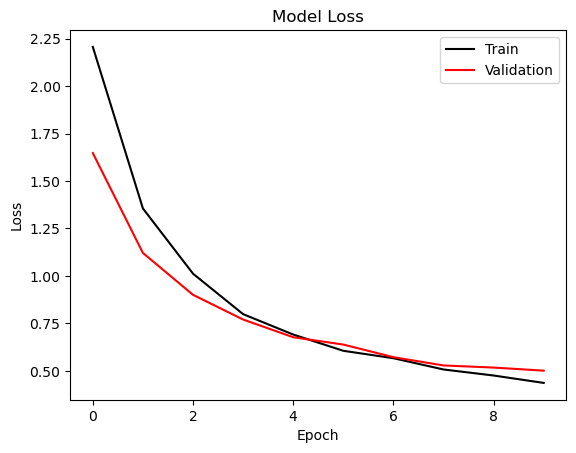

In [22]:
model.loss_plot()

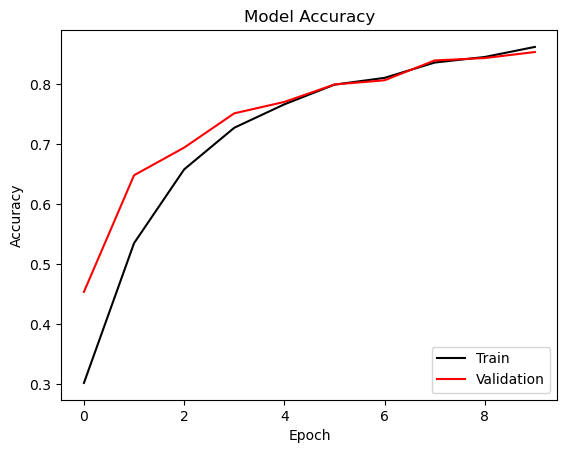

In [23]:
model.accuracy_plot()

In [24]:
y_pred = model.predict(X_test)

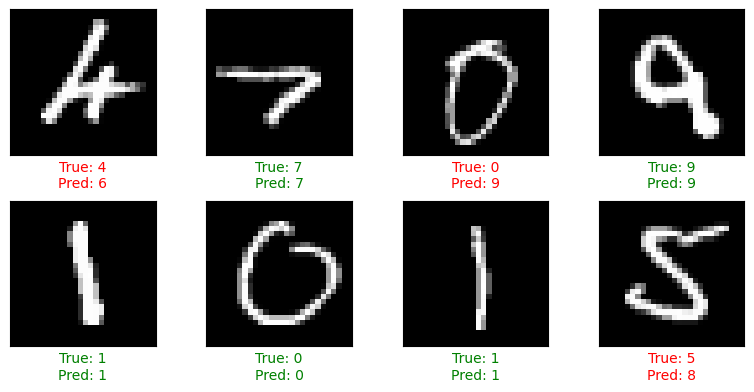

In [35]:
plot_data(X_test.reshape(X_test.shape[0], 28, 28), y_test, y_pred)